In [74]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
import random
import tensorflow as tf

In [93]:
BNA=pd.read_excel("/home/kamal/Desktop/ULI-3/FinalDataset/BNA(10-22).xlsx")
BNA['flight_demand'] = BNA['Departure']+ BNA['Arrival']

In [76]:
# Set seeds for reproducibility
seed_value = 42
random.seed(seed_value)  # Python
np.random.seed(seed_value)  # NumPy
tf.random.set_seed(seed_value)  # TensorFlow/Keras

# Scaling features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(BNA.drop(columns=['DATE', 'Airport']))


X = scaled_data[:, :-1]  # All columns except the last one (Flight_demand)
y = scaled_data[:, -1]

X = X.reshape(X.shape[0], 1, X.shape[1])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

learning_rate = 0.001
adam_optimizer = Adam(learning_rate=learning_rate)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2)) 
model.add(LSTM(units=50))
model.add(Dropout(0.2)) 
model.add(Dense(units=1,kernel_regularizer=l2(0.01)))


# Compile the model
model.compile(optimizer=adam_optimizer, loss='mean_squared_error')

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0.0001, patience=10, verbose=1, mode='min', restore_best_weights=True)


# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1,callbacks=[early_stopping] )

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print('Test Loss:', loss)

# Make predictions
predictions = model.predict(X_test)

Epoch 1/100


/home/kamal/Desktop/ULI-3/ULIvenv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2849/2849 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.0044 - val_loss: 2.3267e-04
Epoch 2/100
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 2.3493e-04 - val_loss: 1.8606e-04
Epoch 3/100
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 2.1306e-04 - val_loss: 1.8333e-04
Epoch 4/100
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 1.9875e-04 - val_loss: 1.6416e-04
Epoch 5/100
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 1.8937e-04 - val_loss: 1.7341e-04
Epoch 6/100
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 1.8763e-04 - val_loss: 1.5026e-04
Epoch 7/100
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 1.7918e-04 - val_loss: 1.4010e-04
Epoch 8/100
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 1.7748e-04 - val_loss: 1.4919e-04
Epoch 9/100
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 1.7010e-04 - val_loss: 1.4956e-04
Epoch 10/100
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 1.7038e-04 - val_loss: 1.4839e-04
Epoch 11/100
2849/2849 ━━━━━━━━━━━━

In [77]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)

# Calculate R^2 Score
r2 = r2_score(y_test, predictions)

In [78]:
print("MeanSquared Error is", mse)
print("RMSE is",rmse )
print("MAE is", mae)
print("R2", r2)

MeanSquared Error is 0.0001514331632930707
RMSE is 0.012305818269951441
MAE is 0.007639332939718768
R2 0.9636918304699413


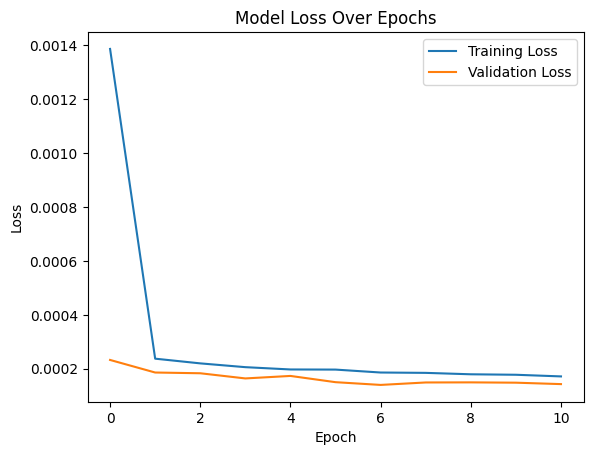

In [79]:
import matplotlib.pyplot as plt

# Assuming 'history' contains the training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Univariate

In [94]:
# Scaling the 'Flight_demand' feature
scaler = MinMaxScaler(feature_range=(0, 1))
flight_demand_scaled = scaler.fit_transform(BNA[['flight_demand']])

# Function to create a dataset for univariate time series
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Specify the number of time steps you want to look back
time_step = 5
X, y = create_dataset(flight_demand_scaled, time_step)

# Reshape X for LSTM model
X = X.reshape(X.shape[0], X.shape[1], 1)  # Make it [samples, time steps, features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Specify the learning rate
learning_rate = 0.001
adam_optimizer = Adam(learning_rate=learning_rate)

# Build the LSTM model for univariate time series
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_regularizer=l2(0.01)))

# Compile the model
model.compile(optimizer=adam_optimizer, loss='mean_squared_error')

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min', restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print('Test Loss:', loss)

# Make predictions
predictions = model.predict(X_test)

# Inverting the scaling for a forecasted value
predictions = scaler.inverse_transform(predictions)

Epoch 1/100


/home/kamal/Desktop/ULI-3/ULIvenv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2849/2849 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - loss: 0.0071 - val_loss: 0.0017
Epoch 2/100
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 3/100
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 4/100
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 5/100
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 6/100
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 7/100
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 8/100
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 9/100
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 10/100
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 11/100
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 12/100
2849/28

In [95]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)

# Calculate R^2 Score
r2 = r2_score(y_test, predictions)

print("MeanSquared Error is", mse)
print("RMSE is",rmse )
print("MAE is", mae)
print("R2", r2)

MeanSquared Error is 727.7129525179807
RMSE is 26.976155258264303
MAE is 23.279421844232534
R2 -106393.84760153631


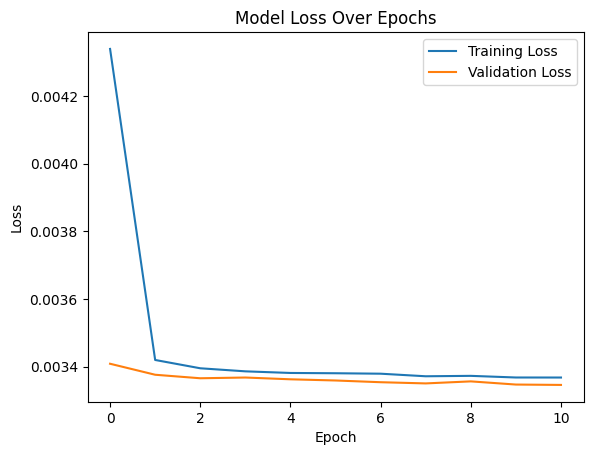

In [83]:
import matplotlib.pyplot as plt

# Assuming 'history' contains the training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()